In [1]:

import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# hv.renderer('bokeh').theme = 'dark_minimal'

In [2]:
# dataset_root = Path(r"C:\Users\Raffael\Documents\Datasets\alpiq_2023") # Raw string works without escaping \
# dataset_root = Path(r"C:/Users/jadbh\Documents/Swisse/EPFL/courses/Fall 2024/Machine Learning for Predictive Maintenance/project/Dataset")
# dataset_root = Path(r"C:\Users\jadbh\Documents\Swisse\EPFL\courses\Fall 2024\Machine Learning for Predictive Maintenance\project\team repo\Machine-Learning-for-Predictive-Maintenance-project\Dataset")
dataset_root = Path(r'Dataset')

@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema
    

rds_u4 = RawDataset(dataset_root, "VG4", load_synthetic=False, load_training=True)
rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True)
rds_u6 = RawDataset(dataset_root, "VG6", load_synthetic=True)

In [3]:
# Training vg5 turbine anomalies

vg5_train_meas = rds_u5.data_dict["train"].measurements
vg5_train_info = rds_u5.data_dict["train"].info
vg5_test_meas = rds_u5.data_dict["test"].measurements
vg5_test_info = rds_u5.data_dict["test"].info

In [4]:
vg5_train_filt_pump = vg5_train_meas [ (vg5_train_meas['equilibrium_short_circuit_mode'] == True)]
    # (vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['dyn_only_on'] == False) ]
                                        #    (vg5_train_meas['equilibrium_turbine_mode'] == True)] 
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == False)) |
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == True) & (vg5_train_meas['equilibrium_short_circuit_mode'] == True)) ]

In [12]:
vg5_s1 = rds_u5.data_dict["test_s01"].measurements          # synthetic testing
vg5_s1.reset_index(inplace=True)
vg5_s1_filt_pump = vg5_s1 [ (vg5_s1['equilibrium_short_circuit_mode'] == True)]
    #  (vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['dyn_only_on'] == False)  ]        # filtered synthetic testing
                    # ((vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['short_circuit_mode'] == False)) |
                    # ((vg5_s1['equilibrium_pump_mode'] == True) & (vg5_s1['short_circuit_mode'] == True) & (vg5_s1['equilibrium_short_circuit_mode'] == True)) ]

In [5]:
vg5_train_meas.reset_index(inplace=True)
vg5_train_filt_pump = vg5_train_meas[ (vg5_train_meas['equilibrium_short_circuit_mode'] == True)]
    # (vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['dyn_only_on'] == False) ]
# [ (vg5_train_meas['equilibrium_turbine_mode'] == True) ]
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == False)) |
                                        #    ((vg5_train_meas['equilibrium_pump_mode'] == True) & (vg5_train_meas['short_circuit_mode'] == True) & (vg5_train_meas['equilibrium_short_circuit_mode'] == True)) ]

In [7]:
# # summary of VG5 useful variables

vg5_train_info
vg5_train_filt_pump     # equilibirum
vg5_train_meas

vg5_test_info
vg5_test_meas

vg5_s1
vg5_s1_filt_pump         # equilibrium

print()

In [6]:
df = vg5_train_filt_pump
print(df.columns)
df.head(3)

Index(['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge',
       'coupler_position', 'injector_01_opening', 'injector_02_opening',
       'injector_03_opening', 'injector_04_opening', 'injector_05_opening',
       'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed',
       'tot_current', 'tot_effectivepower', 'tot_reactivepower',
       'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening',
       'water_primary_pump_02_opening', 'air_circ_cold_01_tmp',
       'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp',
       'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp',
       'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp',
       'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq',
       'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current',
       'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current',
       'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_v

,index,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,injector_01_opening,injector_02_opening,injector_03_opening,injector_04_opening,...,machine_on,machine_off,turbine_mode,all,equilibrium_turbine_mode,dyn_only_on,pump_mode,short_circuit_mode,equilibrium_pump_mode,equilibrium_short_circuit_mode
1225,2020-01-02 10:12:30+01:00,-116.959740,6.187751,17.120198,-1.482010,185.033916,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,True,False,True
1259,2020-01-02 10:29:30+01:00,-116.942245,6.143241,17.201589,-1.525336,185.023748,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,True,False,True
1323,2020-01-02 11:01:30+01:00,-116.976814,6.754509,17.099826,-1.568675,185.053349,0.0,0.0,0.0,0.0,...,True,False,False,True,False,False,False,True,False,True


In [7]:
print("OG columns: ", df.columns.to_list())
print("OG columns length: ", len(df.columns.to_list()))
df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df.drop(['index'], axis = 1, inplace=True)
df.drop(columns= df.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)
print("final columns:       ", df.columns.to_list())
print("final columns lengthL", len(df.columns.to_list()))
df.sample(3)


OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coi

C:\Users\user\AppData\Local\Temp\ipykernel_18224\1347542864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=df.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_18224\1347542864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'], axis = 1, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_18224\1347542864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position
782923,-113.453869,14.613169,19.207285,-115.327720,185.057420,12.968561,338.283356,498.000031,4531.334603,117.239944,...,29.574875,29.299999,29.474958,29.416006,29.400000,29.500000,37.139254,35.539963,35.241971,34.013158
330343,-68.078399,21.509328,15.225973,-68.651560,185.054325,13.709089,378.550018,499.146729,2694.279480,71.289795,...,20.299999,19.966667,19.915000,19.900000,19.929268,20.125000,36.450539,33.659000,37.656735,34.431182
87520,-112.448963,8.151069,15.510315,-113.303669,185.047996,13.109105,347.566681,499.022257,4146.322798,112.652996,...,16.900000,16.400000,16.893023,16.739999,16.720000,17.299999,36.805335,33.375364,36.671572,34.580636


In [13]:
df_test = vg5_s1_filt_pump

print("OG columns: ", df_test.columns.to_list())
print("OG columns length: ", len(df_test.columns.to_list()))
df_test.drop(columns=df_test.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
df_test.drop(['index'], axis = 1, inplace=True)
df_test.drop(columns= df_test.loc[:, 'injector_01_opening':'injector_05_opening'].columns, inplace= True)
print("final columns:       ", df_test.columns.to_list())
print("final columns lengthL", len(df_test.columns.to_list()))
df_test.sample(3)

OG columns:  ['index', 'tot_activepower', 'ext_tmp', 'plant_tmp', 'charge', 'coupler_position', 'injector_01_opening', 'injector_02_opening', 'injector_03_opening', 'injector_04_opening', 'injector_05_opening', 'pump_calculated_flow', 'pump_pressure_diff', 'pump_rotspeed', 'tot_current', 'tot_effectivepower', 'tot_reactivepower', 'turbine_pressure', 'turbine_rotspeed', 'water_primary_pump_01_opening', 'water_primary_pump_02_opening', 'air_circ_cold_01_tmp', 'air_circ_cold_02_tmp', 'air_circ_cold_03_tmp', 'air_circ_cold_04_tmp', 'air_circ_cold_05_tmp', 'air_circ_cold_06_tmp', 'air_circ_hot_01_tmp', 'air_circ_hot_02_tmp', 'air_circ_hot_03_tmp', 'air_circ_hot_04_tmp', 'air_circ_hot_05_tmp', 'air_circ_hot_06_tmp', 'elec_freq', 'exc_current', 'exc_voltage', 'mid_voltage', 'neutral_current', 'ph01_current', 'ph01_voltage', 'ph12_voltage', 'ph02_current', 'ph02_voltage', 'ph23_voltage', 'ph03_current', 'ph03_voltage', 'ph31_voltage', 'stat_coil_ph01_01_tmp', 'stat_coil_ph01_02_tmp', 'stat_coi

C:\Users\user\AppData\Local\Temp\ipykernel_18224\127258494.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=df_test.loc[:, 'machine_on':'equilibrium_short_circuit_mode'].columns, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_18224\127258494.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['index'], axis = 1, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_18224\127258494.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,tot_activepower,ext_tmp,plant_tmp,charge,coupler_position,pump_calculated_flow,pump_pressure_diff,pump_rotspeed,tot_current,tot_effectivepower,...,water_circ_hot_02_tmp,water_circ_hot_03_tmp,water_circ_hot_04_tmp,water_circ_hot_05_tmp,water_circ_hot_06_tmp,water_circ_hot_tmp,air_gap_negative_x_position,air_gap_positive_x_position,air_gap_negative_y_position,air_gap_positive_y_position
70540,-113.014336,26.668502,18.121704,-115.350442,185.065577,13.111234,347.830571,497.013306,4476.932699,117.065517,...,31.320000,30.700000,30.830769,30.772727,30.45,31.900000,38.453003,38.605733,41.244539,37.688744
171028,-113.438328,21.731621,19.414681,-114.690334,185.062818,12.744677,329.542873,498.613403,4273.101759,113.889542,...,31.522222,31.488311,31.563279,31.570625,31.45,31.338888,41.836800,36.561335,36.654873,37.496243
33030,-112.655403,28.506465,17.739843,-115.491999,185.072036,12.896081,336.133354,498.864001,4250.273307,113.269012,...,29.300001,29.100000,29.471428,29.457143,29.60,29.466666,38.220573,35.586259,36.066002,36.671735


In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# Updated scaling function
def scale_data(train_df, test_df, feature_columns, scaler='minmax'):
    """
    Scales data per column using the specified scaler and avoids data leakage.
    Args:
        train_df (pd.DataFrame): Training data
        test_df (pd.DataFrame): Testing data
        feature_columns (list): Columns to be scaled
        scaler (str): Type of scaler ('minmax' or 'robust')
    Returns:
        scaled_train_df, scaled_test_df: Scaled versions of train and test data
        feature_ranges: Ranges of each feature after scaling
    """
    # Initialize the scaler
    if scaler == 'minmax':
        scaler_instance = MinMaxScaler()
    elif scaler == 'robust':
        scaler_instance = RobustScaler()
    else:
        raise ValueError("Unsupported scaler. Choose 'minmax' or 'robust'.")

    # Fit the scaler on training data
    scaler_instance.fit(train_df[feature_columns])

    # Transform both train and test data
    scaled_train_df = train_df.copy()
    scaled_test_df = test_df.copy()
    scaled_train_df[feature_columns] = scaler_instance.transform(train_df[feature_columns])
    scaled_test_df[feature_columns] = scaler_instance.transform(test_df[feature_columns])

    # Compute the range of each feature in the scaled training set
    feature_ranges = pd.DataFrame({
        "Feature": feature_columns,
        "Min": scaled_train_df[feature_columns].min().values,
        "Max": scaled_train_df[feature_columns].max().values
    })

    return scaled_train_df, scaled_test_df, feature_ranges

In [14]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, feature_columns, window_size, step_size=1, max_gap=10, stride = 2):
        """
        Args:
            dataframe (pd.DataFrame): The dataframe containing sensor data.
            feature_columns (list): List of column names for features.
            window_size (int): The number of timesteps in each sliding window.
            step_size (int): The step size to slide the window.
            max_gap (int): Maximum allowed gap between consecutive indices for grouping.
        """
        self.features = dataframe[feature_columns].values
        self.indices = dataframe.index.values
        self.window_size = window_size
        self.step_size = step_size
        self.max_gap = max_gap
        self.stride = stride

        # Identify groups based on index gaps
        self.groups = self._identify_groups()
        # print(self.groups[0:50])
        # print(len(self.groups[500]))
        self.valid_windows = self._generate_valid_windows()

    def _identify_groups(self):
        """
        Identify groups of rows based on the max_gap condition.
        """
        groups = []
        current_group = [0]  # Start with the first row
        for i in range(1, len(self.indices)):
            if self.indices[i] - self.indices[i - 1] > self.max_gap:
                groups.append(current_group)
                current_group = [i]
            else:
                current_group.append(i)
        groups.append(current_group)  # Add the last group
        return groups

    def _generate_valid_windows(self):
        """
        Generate valid sliding windows based on groups.
        """
        valid_windows = []
        for group in self.groups:
            
            for start in range(0, len(group) - self.window_size + 1, self.stride):
                valid_windows.append(group[start : start + self.window_size])

            if (len(group) - self.window_size)%self.stride != 0 and len(group)> self.window_size:
                # print(len(group[len(group) - self.window_size : len(group)]))
                valid_windows.append(group[len(group) - self.window_size : len(group)])

        # print(valid_windows[-1])
        return valid_windows

    def __len__(self):
        return len(self.valid_windows)

    def __getitem__(self, idx):
        """
        Retrieve a sliding window by index.
        """
        window_indices = self.valid_windows[idx]
        x = torch.tensor(self.features[window_indices], dtype=torch.float32)
        return x
    

feature_columns = df.columns

feature_columns_test = df_test.columns
# feature_columns = ["charge"]
# feature_columns = df.columns.to_string()
window_size = 1000
stride = 100
max_gap = 1000
batch_size = 32
step_size = stride  # Step size for sliding window

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle = False)
print("Total df shape:", df.shape)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Total df shape: (105952, 84)
Training set shape: (84761, 84)
Testing set shape: (21191, 84)


Feature Ranges After Scaling:
                        Feature  Min  Max
0               tot_activepower  0.0  1.0
1                       ext_tmp  0.0  1.0
2                     plant_tmp  0.0  1.0
3                        charge  0.0  1.0
4              coupler_position  0.0  1.0
..                          ...  ...  ...
79           water_circ_hot_tmp  0.0  1.0
80  air_gap_negative_x_position  0.0  1.0
81  air_gap_positive_x_position  0.0  1.0
82  air_gap_negative_y_position  0.0  1.0
83  air_gap_positive_y_position  0.0  1.0

[84 rows x 3 columns]


C:\Users\user\AppData\Local\Temp\ipykernel_18224\434491581.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[feature_columns_test] = scaler.transform(df_test[feature_columns_test])  #synthetic anomalies


train dataloader length:  12
train dataloader dataset length:  367
test dataloader length:  4
test dataloader dataset length:  123
Total windows: 367
Total number of groups: 183
Average points per group: 463.1748633879781
Minimum group size: 1


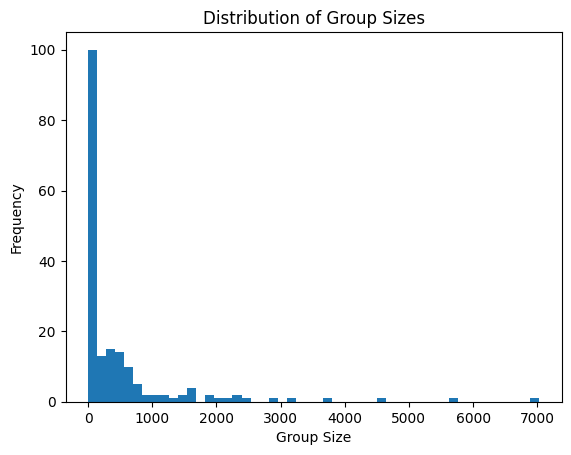

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example dataset setup
# Assuming `df` is already defined
window_size = 1000
stride = 100
max_gap = 1000
batch_size = 32
step_size = stride  # Step size for sliding window


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# Scale the data and get feature ranges
scaled_train_df, scaled_test_df, feature_ranges = scale_data(train_df, test_df, feature_columns, scaler='minmax')


# Display results
print("Feature Ranges After Scaling:")
print(feature_ranges)

# Here I am using the old scaling again, we can use the prints in a presentation or something

# Initialize a scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(train_df[feature_columns])

# Transform the training and testing data
train_df[feature_columns] = scaler.transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])
df_test[feature_columns_test] = scaler.transform(df_test[feature_columns_test])  #synthetic anomalies


# Create Dataset and DataLoader
train_dataset = SlidingWindowDataset(train_df, feature_columns, window_size, step_size, max_gap, stride = stride)
test_dataset = SlidingWindowDataset(test_df, feature_columns, window_size, step_size, max_gap, stride = stride)
synth_test =  SlidingWindowDataset(df_test, feature_columns, window_size, step_size, max_gap, stride = stride)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
synth_test_loader = DataLoader(synth_test, batch_size=batch_size, shuffle=True)

print("train dataloader length: ", len(train_dataloader))
print("train dataloader dataset length: ", len(train_dataloader.dataset))

print("test dataloader length: ", len(test_dataloader))
print("test dataloader dataset length: ", len(test_dataloader.dataset))

print(f"Total windows: {len(train_dataset)}")
print(f"Total number of groups: {len(train_dataset.groups)}")
print(f"Average points per group: {np.mean([len(group) for group in train_dataset.groups])}")
group_sizes = [len(group) for group in train_dataset.groups]
print(f"Minimum group size: {min(group_sizes)}")
plt.hist(group_sizes, bins=50)
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.title('Distribution of Group Sizes')
plt.show()

In [16]:
def add_noise(x, noise_factor=0.1):
    """
    Adds Gaussian noise to the input tensor.
    Args:
        x (torch.Tensor): Input tensor.
        noise_factor (float): Scale of noise to add.
    Returns:
        torch.Tensor: Noisy input tensor.
    """
    noisy_x = x + noise_factor * torch.randn_like(x)
    noisy_x = torch.clamp(noisy_x, 0, 1)  # Ensure values remain in the valid range
    return noisy_x

def custom_loss(x, x_reconstructed, encoded, sparsity_weight=1e-3):
    """
    Combines reconstruction loss with a sparsity constraint on the latent space.
    Args:
        x (torch.Tensor): Original input tensor.
        x_reconstructed (torch.Tensor): Reconstructed tensor.
        encoded (torch.Tensor): Latent representation.
        sparsity_weight (float): Weight for the sparsity penalty.
    Returns:
        torch.Tensor: Combined loss.
    """
    reconstruction_loss = nn.MSELoss()(x_reconstructed, x)
    sparsity_loss = torch.mean(torch.abs(encoded))  # L1 penalty for sparsity
    return reconstruction_loss + sparsity_weight * sparsity_loss


## Training loop with noise injection to improve robustness and residual connections 

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_len):
        super(ResidualConvAutoencoder, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([256, seq_len]),
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len//2]),
            nn.Dropout(p=0.2)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//4])
        )
        self.encoder_pool = nn.MaxPool1d(2)  # Down-sampling at each stage

        # Latent space (larger latent space)
        self.latent = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1),  # Additional latent layer
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//8])
        )

        # Decoder
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose1d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([64, seq_len//4])
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose1d(64+64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([128, seq_len//2]),
            nn.Dropout(p=0.2)
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose1d(128+128, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.LayerNorm([256, seq_len])
        )
        self.output_layer = nn.Sequential(
            nn.Conv1d(256+256, input_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Ensures output is in the range [0, 1]
        )

    def forward(self, x):
        """
        Forward pass with residual connections and latent space.
        """
        # Encoder
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, features) -> (batch_size, features, seq_len)
        skip1 = self.encoder_conv1(x)  # First layer output for skip connection
        # print("ENCODER LAYER: 1",skip1.shape)
        skip2 = self.encoder_conv2(self.encoder_pool(skip1))  # Second layer output for skip
        # print("ENCODER LAYER: 2",skip2.shape)
        encoded = self.encoder_conv3(self.encoder_pool(skip2))  # Latent input
        # print("ENCODER LAYER: 3",encoded.shape)
        latent = self.latent(self.encoder_pool(encoded))  # Latent representation
        # print("ENCODER LAYER: 4",latent.shape)

        # Decoder
        decoded = self.decoder_conv1(latent)
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded, encoded), dim=1)  # Align dimensions for skip connection
        # print("RECONSTRUCTED: ",decoded.shape)
        decoded = self.decoder_conv2(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip2), dim=1)  # Align dimensions for skip connection
        decoded = self.decoder_conv3(decoded)
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        decoded = torch.cat((decoded,skip1), dim=1)  # Align dimensions for skip connection
        decoded = self.output_layer(decoded)  # Final reconstruction
        # print("FULLY RECONSTRUCTED: ",decoded.shape)
        # Revert to (batch_size, seq_len, features)
        return decoded.permute(0, 2, 1), latent


In [18]:
import torch
import numpy as np
import random
from tqdm import tqdm

def train_loop(dataloader, model, optimizer, noise_factor=0.1, sparsity_weight=1e-3):
    model.train()
    total_loss = 0

    for x in tqdm(dataloader):
        optimizer.zero_grad()

        # Add noise to input
        # noisy_x = add_noise(x, noise_factor)

        # Forward pass
        reconstructed, encoded = model(x)

        # Compute loss
        loss = custom_loss(x, reconstructed, encoded, sparsity_weight)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def test_loop(dataloader, model, sparsity_weight=1e-3):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x in dataloader:
            reconstructed, encoded = model(x)
            loss = custom_loss(x, reconstructed, encoded, sparsity_weight)
            total_loss += loss.item()

    return total_loss / len(dataloader)



def set_seed(seed=42):
    """
    Set a constant seed for reproducibility across all libraries.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # Numpy
    torch.manual_seed(seed)  # PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids nondeterministic algorithms



## Training loop with noise injection for robustness, introducing sparcity loss, batchnorm and dropout for overfitting and stability, and early stopping to get the best model

In [21]:
set_seed(42)
# Hyperparameters
epochs = 200
learning_rate = 0.001
noise_factor = 0.1
sparsity_weight = 1e-3

# Model, optimizer, and dataloaders
input_dim = 84  # for pump, and 85 for turbine
seq_len = 1000
model = ResidualConvAutoencoder(input_dim, seq_len)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loss_evol, test_loss_evol = [], []

best_test_loss = float('inf')
patience = 10
patience_counter = 0

In [18]:
for x in train_dataloader:
    print(x.shape)  # Verify shape
    break


torch.Size([32, 1000, 84])


In [22]:
# TRAINING LOOP:
# print(model)
for epoch in range(epochs):
    train_loss = train_loop(train_dataloader, model, optimizer, noise_factor, sparsity_weight)
    test_loss = test_loop(test_dataloader, model, sparsity_weight)

    print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {test_loss}")
    train_loss_evol.append(train_loss)
    test_loss_evol.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0  # Reset patience
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"New best model at epoch {epoch}")
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print(f"Early stopping at epoch {epoch}")
    #         break




100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch: 0, Training Loss: 0.024706089325870078, Validation Loss: 0.008163316524587572
New best model at epoch 0


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch: 1, Training Loss: 0.005891747268227239, Validation Loss: 0.00448510458227247
New best model at epoch 1


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 2, Training Loss: 0.0038203230942599475, Validation Loss: 0.0036798708606511354
New best model at epoch 2


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch: 3, Training Loss: 0.0029577239571760097, Validation Loss: 0.003266602521762252
New best model at epoch 3


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch: 4, Training Loss: 0.0024721402442082763, Validation Loss: 0.002816485648509115
New best model at epoch 4


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 5, Training Loss: 0.0021165715200671307, Validation Loss: 0.0024516204139217734
New best model at epoch 5


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 6, Training Loss: 0.001860801091728111, Validation Loss: 0.0022141128429211676
New best model at epoch 6


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 7, Training Loss: 0.0016589609149377793, Validation Loss: 0.0021150725660845637
New best model at epoch 7


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 8, Training Loss: 0.0015137003307851653, Validation Loss: 0.00212310126516968


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 9, Training Loss: 0.0013927000206119071, Validation Loss: 0.0016849026433192194
New best model at epoch 9


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 10, Training Loss: 0.0012934829186027248, Validation Loss: 0.0016526857216376811
New best model at epoch 10


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 11, Training Loss: 0.0011743547996350874, Validation Loss: 0.0016405558562837541
New best model at epoch 11


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch: 12, Training Loss: 0.0010942238489709173, Validation Loss: 0.0016967862902674824


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 13, Training Loss: 0.001045848912326619, Validation Loss: 0.0013812871475238353
New best model at epoch 13


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 14, Training Loss: 0.0009243474438941727, Validation Loss: 0.00124792629503645
New best model at epoch 14


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 15, Training Loss: 0.000838975072838366, Validation Loss: 0.0012104827328585088
New best model at epoch 15


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 16, Training Loss: 0.0007780197677978625, Validation Loss: 0.0010648854949977249
New best model at epoch 16


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch: 17, Training Loss: 0.0007701188393790895, Validation Loss: 0.001144120004028082


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch: 18, Training Loss: 0.0007315747692094495, Validation Loss: 0.0009715349151520059
New best model at epoch 18


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 19, Training Loss: 0.0006617842785393199, Validation Loss: 0.0009508290968369693
New best model at epoch 19


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 20, Training Loss: 0.0006628363432052234, Validation Loss: 0.0009646196849644184


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Epoch: 21, Training Loss: 0.0006290202242477486, Validation Loss: 0.000787937970017083
New best model at epoch 21


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Epoch: 22, Training Loss: 0.0005743170744002176, Validation Loss: 0.000802994254627265


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 23, Training Loss: 0.0005350067294784822, Validation Loss: 0.0008240486640715972


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Epoch: 24, Training Loss: 0.000679528903371344, Validation Loss: 0.0007458363397745416
New best model at epoch 24


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Epoch: 25, Training Loss: 0.0005699478109211972, Validation Loss: 0.0009244730463251472


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch: 26, Training Loss: 0.0006008844890554125, Validation Loss: 0.0007834791322238743


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 27, Training Loss: 0.0005174461378677128, Validation Loss: 0.0007811144314473495


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 28, Training Loss: 0.0004949148933519609, Validation Loss: 0.0008921493572415784


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 29, Training Loss: 0.0004877158329084826, Validation Loss: 0.0006546986987814307
New best model at epoch 29


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 30, Training Loss: 0.00044051255584539223, Validation Loss: 0.0006043310422683135
New best model at epoch 30


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 31, Training Loss: 0.0004409565663081594, Validation Loss: 0.0005721102497773245
New best model at epoch 31


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 32, Training Loss: 0.00048496859380975366, Validation Loss: 0.0005690434481948614
New best model at epoch 32


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch: 33, Training Loss: 0.0004438456865803649, Validation Loss: 0.0005147299307282083
New best model at epoch 33


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 34, Training Loss: 0.00038864637948184583, Validation Loss: 0.0005857352225575596


100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Epoch: 35, Training Loss: 0.0003731058313860558, Validation Loss: 0.0005583694000961259


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 36, Training Loss: 0.000430382516545554, Validation Loss: 0.0005520376143977046


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 37, Training Loss: 0.00039049503053926554, Validation Loss: 0.0005278553871903569


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 38, Training Loss: 0.0004749724854870389, Validation Loss: 0.0007603925332659855


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 39, Training Loss: 0.0005530161191321289, Validation Loss: 0.0011446706776041538


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 40, Training Loss: 0.0005341021023923531, Validation Loss: 0.0007560480153188109


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 41, Training Loss: 0.00046398951720523957, Validation Loss: 0.00061265510157682


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 42, Training Loss: 0.0004439910699147731, Validation Loss: 0.0005288220854708925


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 43, Training Loss: 0.0003906891991694768, Validation Loss: 0.0006139567558420822


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 44, Training Loss: 0.0003568017224703605, Validation Loss: 0.00044852901191916317
New best model at epoch 44


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 45, Training Loss: 0.0003019351728047089, Validation Loss: 0.00043920150346821174
New best model at epoch 45


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 46, Training Loss: 0.0002950687849079259, Validation Loss: 0.00047355271090054885


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch: 47, Training Loss: 0.0003085306379944086, Validation Loss: 0.00048117627011379227


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch: 48, Training Loss: 0.00029931001336080953, Validation Loss: 0.00045030086766928434


100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Epoch: 49, Training Loss: 0.00032041060452077846, Validation Loss: 0.00044457241165218875


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 50, Training Loss: 0.00028251497011903365, Validation Loss: 0.0004838628592551686


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 51, Training Loss: 0.0003227976618897325, Validation Loss: 0.0009083847544388846


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 52, Training Loss: 0.00042459539205689606, Validation Loss: 0.0004012658100691624
New best model at epoch 52


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch: 53, Training Loss: 0.00030340183487472433, Validation Loss: 0.0004915841855108738


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch: 54, Training Loss: 0.0002702568126551341, Validation Loss: 0.000417988580011297


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 55, Training Loss: 0.00024135069058199102, Validation Loss: 0.00036574881960405037
New best model at epoch 55


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 56, Training Loss: 0.000216993278930507, Validation Loss: 0.00040697022632230073


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 57, Training Loss: 0.00020722392703949785, Validation Loss: 0.0003561868143151514
New best model at epoch 57


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 58, Training Loss: 0.0002303576135697464, Validation Loss: 0.00035197348188376054
New best model at epoch 58


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch: 59, Training Loss: 0.0002659316754337245, Validation Loss: 0.0003636881447164342


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch: 60, Training Loss: 0.00023899709898008345, Validation Loss: 0.0003302762415842153
New best model at epoch 60


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 61, Training Loss: 0.00024686792433688726, Validation Loss: 0.0004954695905325934


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 62, Training Loss: 0.0005144214131481325, Validation Loss: 0.000485202792333439


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 63, Training Loss: 0.000413982537187015, Validation Loss: 0.00039826397551223636


100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Epoch: 64, Training Loss: 0.000305082513174663, Validation Loss: 0.0004136919305892661


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch: 65, Training Loss: 0.00023825558916238757, Validation Loss: 0.0004517277411650866


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 66, Training Loss: 0.00020026117393475337, Validation Loss: 0.00038558932283194736


100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Epoch: 67, Training Loss: 0.000180227081727935, Validation Loss: 0.0003072109757340513
New best model at epoch 67


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch: 68, Training Loss: 0.00019248485962937897, Validation Loss: 0.0003563257705536671


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch: 69, Training Loss: 0.00017105663694868176, Validation Loss: 0.00032170680060517043


100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Epoch: 70, Training Loss: 0.00016043385160931697, Validation Loss: 0.0003226636763429269


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 71, Training Loss: 0.00015264942703652196, Validation Loss: 0.00028975449822610244
New best model at epoch 71


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 72, Training Loss: 0.0001588194900250528, Validation Loss: 0.00028249394381418824
New best model at epoch 72


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 73, Training Loss: 0.0001533693321107421, Validation Loss: 0.0002818915163516067
New best model at epoch 73


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 74, Training Loss: 0.0001429787601712936, Validation Loss: 0.00027483335725264624
New best model at epoch 74


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 75, Training Loss: 0.00013798880415076079, Validation Loss: 0.00025868781813187525
New best model at epoch 75


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 76, Training Loss: 0.00013802642691492414, Validation Loss: 0.00028132904117228463


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 77, Training Loss: 0.00018627037934493273, Validation Loss: 0.00032460418151458725


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 78, Training Loss: 0.0006400169222615659, Validation Loss: 0.0007551474991487339


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 79, Training Loss: 0.0004907641947890321, Validation Loss: 0.00048697756574256346


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 80, Training Loss: 0.00032871873312008876, Validation Loss: 0.0004255008898326196


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 81, Training Loss: 0.00024105194218767187, Validation Loss: 0.0002737472750595771


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 82, Training Loss: 0.00017623974054004066, Validation Loss: 0.0002600669613457285


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 83, Training Loss: 0.00016042825275993286, Validation Loss: 0.00032325013307854533


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 84, Training Loss: 0.00015642268772353418, Validation Loss: 0.00030492481164401397


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 85, Training Loss: 0.00015023908417788334, Validation Loss: 0.0002665251558937598


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 86, Training Loss: 0.00014672791439807042, Validation Loss: 0.00029977170197525993


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 87, Training Loss: 0.00014809995203298362, Validation Loss: 0.00031318784022005275


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 88, Training Loss: 0.00017429385601038425, Validation Loss: 0.0003146995877614245


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 89, Training Loss: 0.00015930153919422688, Validation Loss: 0.0002638221521920059


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 90, Training Loss: 0.00014946140436222777, Validation Loss: 0.0002489825383236166
New best model at epoch 90


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 91, Training Loss: 0.00014952003160336366, Validation Loss: 0.00028130514692747965


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 92, Training Loss: 0.00014477779162310375, Validation Loss: 0.0003078221925534308


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 93, Training Loss: 0.00014322164255039146, Validation Loss: 0.00027025913004763424


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 94, Training Loss: 0.00012981431609659921, Validation Loss: 0.00025469285174040124


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 95, Training Loss: 0.00012629644819147265, Validation Loss: 0.000291812903014943


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch: 96, Training Loss: 0.00011948465241099863, Validation Loss: 0.00024032236251514405
New best model at epoch 96


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 97, Training Loss: 0.00011634106037187546, Validation Loss: 0.0003572439818526618


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 98, Training Loss: 0.00015727722408579817, Validation Loss: 0.00031906870572129264


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 99, Training Loss: 0.00018513390872006616, Validation Loss: 0.00040046418143901974


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 100, Training Loss: 0.00018657078544492833, Validation Loss: 0.00027979895094176754


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 101, Training Loss: 0.00018722219586682817, Validation Loss: 0.0003944256459362805


100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch: 102, Training Loss: 0.00026925574032550986, Validation Loss: 0.00028884065250167623


100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


Epoch: 103, Training Loss: 0.0002072011775453575, Validation Loss: 0.00031415878765983507


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Epoch: 104, Training Loss: 0.00012392883642557231, Validation Loss: 0.0002290381380589679
New best model at epoch 104


100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch: 105, Training Loss: 0.00011220481064810883, Validation Loss: 0.00023721524485154077


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 106, Training Loss: 0.00010610875748776986, Validation Loss: 0.0002332898511667736


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 107, Training Loss: 0.00011043261110899039, Validation Loss: 0.0002404081533313729


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 108, Training Loss: 0.00015754697718269503, Validation Loss: 0.00022843496117275208
New best model at epoch 108


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 109, Training Loss: 0.0001600988337789507, Validation Loss: 0.0002591932498035021


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 110, Training Loss: 0.00016097551633720286, Validation Loss: 0.0003158898325636983


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 111, Training Loss: 0.00012337653121600548, Validation Loss: 0.0002378718818363268


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 112, Training Loss: 0.00012142483683419414, Validation Loss: 0.0002358166930207517


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 113, Training Loss: 0.0001300448402616894, Validation Loss: 0.00029695487319258973


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 114, Training Loss: 0.00011473461442316572, Validation Loss: 0.00021183213175390847
New best model at epoch 114


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 115, Training Loss: 0.00010523837894046058, Validation Loss: 0.00020896066780551337
New best model at epoch 115


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 116, Training Loss: 0.00010325006708929625, Validation Loss: 0.00021728316278313287


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 117, Training Loss: 0.00010976838893839158, Validation Loss: 0.00021738277791882865


100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 118, Training Loss: 0.00010157099616966055, Validation Loss: 0.00022459008323494345


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 119, Training Loss: 0.00010921141317036624, Validation Loss: 0.00031447580840904266


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 120, Training Loss: 0.00014575724344467744, Validation Loss: 0.000210961759876227


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 121, Training Loss: 0.0001103341273847036, Validation Loss: 0.0001991813514905516
New best model at epoch 121


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 122, Training Loss: 9.897281779558398e-05, Validation Loss: 0.0002139560237992555


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 123, Training Loss: 0.00010464330625836737, Validation Loss: 0.00019779389185714535
New best model at epoch 123


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 124, Training Loss: 0.00012582718287982667, Validation Loss: 0.0002065285516437143


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 125, Training Loss: 0.00012727401614635406, Validation Loss: 0.00042276489693904296


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 126, Training Loss: 0.00021030510045723835, Validation Loss: 0.00035499694058671594


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 127, Training Loss: 0.00019737627007998526, Validation Loss: 0.0002793390885926783


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 128, Training Loss: 0.0001926402716586987, Validation Loss: 0.0002773214873741381


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 129, Training Loss: 0.00016730385808235346, Validation Loss: 0.0002634264383232221


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 130, Training Loss: 0.00016221724460289502, Validation Loss: 0.00023023083485895768


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


Epoch: 131, Training Loss: 0.00012121354969470606, Validation Loss: 0.00022812746465206146


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 132, Training Loss: 0.00010889364542284359, Validation Loss: 0.0001895183013402857
New best model at epoch 132


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 133, Training Loss: 9.538608355796896e-05, Validation Loss: 0.0001865991835074965
New best model at epoch 133


100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 134, Training Loss: 9.25182387921571e-05, Validation Loss: 0.00017098957687267102
New best model at epoch 134


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 135, Training Loss: 0.00016894672080525197, Validation Loss: 0.0002611817908473313


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 136, Training Loss: 0.0001822427693696227, Validation Loss: 0.00017622737868805416


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 137, Training Loss: 0.00031043949942007504, Validation Loss: 0.00043123230716446415


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch: 138, Training Loss: 0.00016281382280188458, Validation Loss: 0.00025001008543767966


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch: 139, Training Loss: 0.0001203474863965918, Validation Loss: 0.0002372263370489236


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 140, Training Loss: 0.00012942988905706443, Validation Loss: 0.0002665334177436307


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch: 141, Training Loss: 0.0001281951529866395, Validation Loss: 0.0001975186423806008


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch: 142, Training Loss: 9.590727556011795e-05, Validation Loss: 0.0001915082939376589


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch: 143, Training Loss: 8.608154954951412e-05, Validation Loss: 0.00020032831162097864


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch: 144, Training Loss: 8.469090668465166e-05, Validation Loss: 0.00016153098476934247
New best model at epoch 144


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 145, Training Loss: 0.00010899073822656646, Validation Loss: 0.0002132349145540502


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 146, Training Loss: 0.00022976148466113955, Validation Loss: 0.00029741569596808404


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 147, Training Loss: 0.00015910751729582748, Validation Loss: 0.0002590274380054325


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 148, Training Loss: 0.00012013301784463692, Validation Loss: 0.00025861308677121997


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 149, Training Loss: 9.858718173442564e-05, Validation Loss: 0.00018920172078651376


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 150, Training Loss: 0.00010084615011389057, Validation Loss: 0.0001952234742930159


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 151, Training Loss: 0.00010510297336926062, Validation Loss: 0.00020160608619335108


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 152, Training Loss: 0.00011769848242693115, Validation Loss: 0.00017816185572883114


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 153, Training Loss: 9.408113449656715e-05, Validation Loss: 0.00016078113549156114
New best model at epoch 153


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 154, Training Loss: 8.897963258884072e-05, Validation Loss: 0.0001419973596057389
New best model at epoch 154


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 155, Training Loss: 9.509706069366075e-05, Validation Loss: 0.00018520413505029865


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 156, Training Loss: 9.28261318525377e-05, Validation Loss: 0.00016978094936348498


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch: 157, Training Loss: 0.0001214033169768906, Validation Loss: 0.0001673979604674969


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 158, Training Loss: 0.00011012418932902317, Validation Loss: 0.00017502942864666693


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 159, Training Loss: 0.00011850416922243312, Validation Loss: 0.0002579233405413106


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 160, Training Loss: 0.00015825773092122594, Validation Loss: 0.00019693875219672918


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 161, Training Loss: 0.00016908887482713908, Validation Loss: 0.00021225332966423593


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 162, Training Loss: 0.00015668993304037335, Validation Loss: 0.00018881586220231839


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 163, Training Loss: 0.0001377517025199874, Validation Loss: 0.00029790375992888585


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 164, Training Loss: 0.0001432541866961401, Validation Loss: 0.00022313549197860993


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 165, Training Loss: 0.0001087757070005561, Validation Loss: 0.0001858716132119298


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 166, Training Loss: 0.00010259184091410134, Validation Loss: 0.0002256196239613928


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 167, Training Loss: 0.00010339059311566719, Validation Loss: 0.00018099693625117652


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 168, Training Loss: 0.00011481786956816602, Validation Loss: 0.0003131885969196446


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 169, Training Loss: 0.00012822575687702434, Validation Loss: 0.00018665276729734614


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 170, Training Loss: 0.00011093240209447686, Validation Loss: 0.0001974351835087873


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 171, Training Loss: 8.563349122899429e-05, Validation Loss: 0.00017781431597541086


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 172, Training Loss: 8.314734319962251e-05, Validation Loss: 0.00016265648810076527


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 173, Training Loss: 9.032543675857596e-05, Validation Loss: 0.00025049427858903073


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 174, Training Loss: 9.029622621407422e-05, Validation Loss: 0.00017514433056931011


100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Epoch: 175, Training Loss: 0.00014620019646827132, Validation Loss: 0.00032090219610836357


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 176, Training Loss: 0.0001921013681567274, Validation Loss: 0.00018658023691386916


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch: 177, Training Loss: 9.612674330128357e-05, Validation Loss: 0.00016120697910082527


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 178, Training Loss: 8.596897593330748e-05, Validation Loss: 0.00019489139958750457


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 179, Training Loss: 7.881150850153062e-05, Validation Loss: 0.0001693957528914325


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 180, Training Loss: 7.29005123503157e-05, Validation Loss: 0.00014714420831296593


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 181, Training Loss: 6.808300895499997e-05, Validation Loss: 0.00015255262042046525


100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Epoch: 182, Training Loss: 6.89384311651035e-05, Validation Loss: 0.0001554763875901699


100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 183, Training Loss: 7.231203380797524e-05, Validation Loss: 0.00014094565631239675
New best model at epoch 183


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 184, Training Loss: 7.773566600614383e-05, Validation Loss: 0.00019825984418275766


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 185, Training Loss: 0.00010776771402258116, Validation Loss: 0.00021202858988544904


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Epoch: 186, Training Loss: 0.00011247956657219522, Validation Loss: 0.00021489663413376547


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 187, Training Loss: 9.204537976377954e-05, Validation Loss: 0.00016584092372795567


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 188, Training Loss: 9.588725515641272e-05, Validation Loss: 0.00020565280283335596


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 189, Training Loss: 0.00012657811870061172, Validation Loss: 0.0001627000492590014


100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


Epoch: 190, Training Loss: 0.0002314972643944202, Validation Loss: 0.00028168064454803243


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 191, Training Loss: 0.00016485203317036698, Validation Loss: 0.0001675709972914774


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 192, Training Loss: 0.00011747088440946148, Validation Loss: 0.00016090385179268196


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 193, Training Loss: 0.00010337272639541577, Validation Loss: 0.0001389470780850388
New best model at epoch 193


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Epoch: 194, Training Loss: 0.00011302302239831381, Validation Loss: 0.00025736506358953193


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 195, Training Loss: 0.00012498380904920245, Validation Loss: 0.00018758250735118054


100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Epoch: 196, Training Loss: 0.00010968062391233009, Validation Loss: 0.0002043242784566246


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Epoch: 197, Training Loss: 8.523540964233689e-05, Validation Loss: 0.00014888155419612303


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 198, Training Loss: 7.027463288977742e-05, Validation Loss: 0.00013750995276495814
New best model at epoch 198


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


Epoch: 199, Training Loss: 6.307564459954544e-05, Validation Loss: 0.00013801059321849607


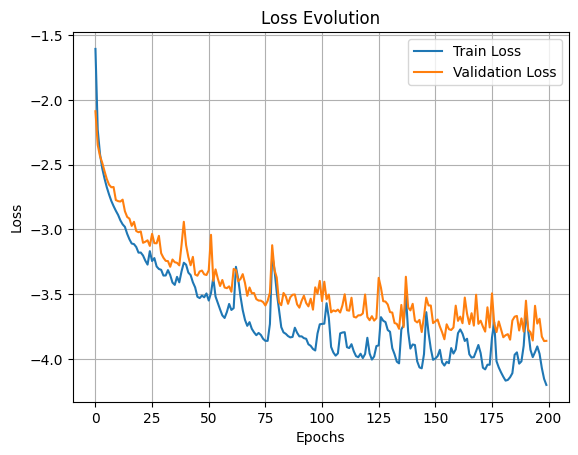

In [260]:
# Plot loss evolution
import matplotlib.pyplot as plt

plt.plot(np.log10(train_loss_evol), label='Train Loss')
plt.plot(np.log10(test_loss_evol), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.grid()
plt.show()

Batch shape: torch.Size([32, 1000, 84])
Single sample shape: torch.Size([1, 1000, 84])


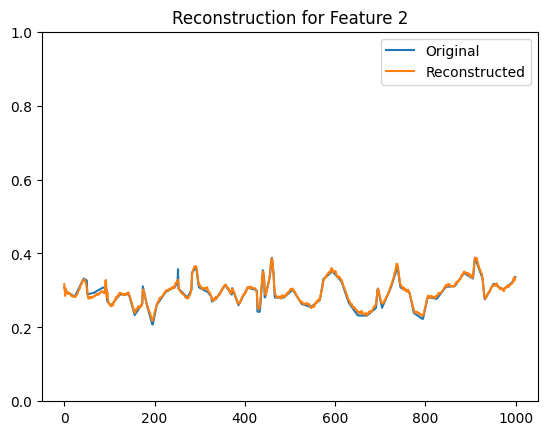

In [244]:
# Access the first batch of the test dataloader
with torch.no_grad():
    # Get the first batch from the dataloader
    for x in test_dataloader:
        # x will have the shape (batch_size, seq_len, num_features)
        print("Batch shape:", x.shape)
        
        # Use only the first element in the batch
        x_sample = x[0].unsqueeze(0)  # Shape: (1, seq_len, num_features)
        print("Single sample shape:", x_sample.shape)
        
        # Pass it through the model
        reconstructed, _ = model(x_sample)
        
        # Remove batch dimension for visualization
        x_sample = x_sample.squeeze(0)  # Shape: (seq_len, num_features)
        reconstructed = reconstructed.squeeze(0)  # Shape: (seq_len, num_features)
        
        # Plot the original and reconstructed signal for one feature
        feature_index = 2
          # Adjust to visualize a specific feature
        plt.plot(x_sample[:, feature_index].cpu().numpy(), label="Original")
        plt.plot(reconstructed[:, feature_index].cpu().numpy(), label="Reconstructed")
        plt.legend()
        plt.title(f"Reconstruction for Feature {feature_index}")
        plt.ylim([0, 1])
        plt.show()
        
        # Break after first batch
        break


In [57]:
model.load_state_dict(torch.load("best_model.pth"))  # Load the trained model weights
model.eval()  # Set the model to evaluation mode


C:\Users\user\AppData\Local\Temp\ipykernel_18224\3501737622.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))  # Load t

ResidualConvAutoencoder(
  (encoder_conv1): Sequential(
    (0): Conv1d(84, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((256, 1000), eps=1e-05, elementwise_affine=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((128, 500), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 250), eps=1e-05, elementwise_affine=True)
  )
  (encoder_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (latent): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): LayerNorm((64, 125), eps=1e-05, elementwise_affine=True)
  )
  (decoder_conv1): Sequential(
    (0): ConvTranspose1d(64, 64, kernel_size=(2,), stride=(2,))
    

In [ ]:
import torch

# Disable gradient computation for evaluation
with torch.no_grad():
    total_loss = 0
    # full_reconstruction = torch.Tensor([])
    for x in synth_test_loader:
        # inputs, _ = batch  # Adjust this based on your data structure
        outputs, encoded = model(x)  # Forward pass through the model
        
        # Compute loss (if applicable)
        # full_reconstruction = torch.cat((full_reconstruction, outputs), dim=0)
        loss = custom_loss(x, outputs, encoded, sparsity_weight)  # Replace `loss_function` with your criterion
        total_loss += loss.item()
        
        # You can also compute additional metrics like accuracy or reconstruction error here

print(f"Test Loss: {total_loss / len(synth_test_loader)}")


Test Loss: 0.001761823077686131


Batch shape: torch.Size([29, 1000, 84])
Single sample shape: torch.Size([1, 1000, 84])


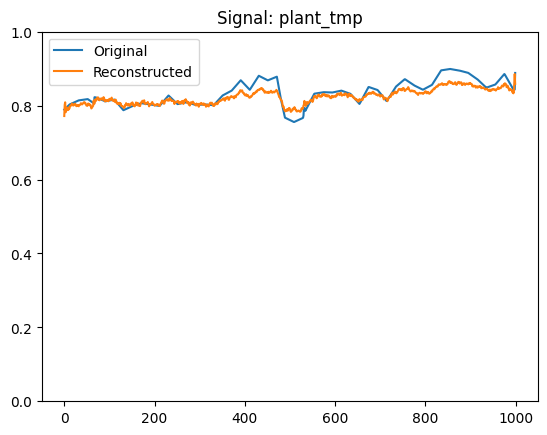

In [256]:
# Access the first batch of the test dataloader
with torch.no_grad():
    # Get the first batch from the dataloader
    for x in synth_test_loader:
        # x will have the shape (batch_size, seq_len, num_features)
        print("Batch shape:", x.shape)
        
        # Use only the first element in the batch
        x_sample = x[0].unsqueeze(0)  # Shape: (1, seq_len, num_features)
        print("Single sample shape:", x_sample.shape)
        
        # Pass it through the model
        reconstructed, _ = model(x_sample)
        
        # Remove batch dimension for visualization
        x_sample = x_sample.squeeze(0)  # Shape: (seq_len, num_features)
        reconstructed = reconstructed.squeeze(0)  # Shape: (seq_len, num_features)
        
        # Plot the original and reconstructed signal for one feature
        feature_index = 2  # Adjust to visualize a specific feature
        plt.plot(x_sample[:, feature_index].cpu().numpy(), label="Original")
        plt.plot(reconstructed[:, feature_index].cpu().numpy(), label="Reconstructed")
        plt.legend()
        plt.title(f"Signal: {df.columns[feature_index]}")
        plt.ylim([0,1])
        plt.show()
        
        # Break after first batch
        break
